In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm


# Text Preprocessing and NLP
import nltk

# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords

# Tokenizing sentences/words
from nltk.tokenize import word_tokenize

# Part-of-speech tagging
from nltk import pos_tag

# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer

In [3]:
import os
import sys
from pathlib import Path

if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("working dir:", workding_dir)

working dir: /home/inflaton/code/CrediNews


# Data Preparation (Loading CSV)

Load the processed_data `csv` file into pandas DataFrames
- `processed_data.csv` is loaded into `data` DataFrame (stemming has been performed to reduce processing time.)

In [4]:
from datasets import load_dataset, concatenate_datasets, Dataset

datasets = load_dataset(
    "csv",
    data_files={
        "train": [
            "dataset/train_data_1.csv",
            "dataset/train_data_2.csv",
            "dataset/train_data_3.csv",
            "dataset/train_data_4.csv",
        ],
        "test": "dataset/test_data.csv",
        "rewritten_train": [
            "dataset/rewritten_train_data_1.csv",
            "dataset/rewritten_train_data_2.csv",
            "dataset/rewritten_train_data_3.csv",
            "dataset/rewritten_train_data_4.csv",
        ],
        "rewritten_test": "dataset/rewritten_test_data.csv",
    },
)
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
    rewritten_train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    rewritten_test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
})

### Convolutional Neural network + Custom-trained word2vec word embeddings + 5-Fold Cross Validation + L2 Regularization + GridSearchCV


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    Input,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from gensim.models import Word2Vec
from tensorflow.keras.regularizers import l2

# Set seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


def train_word2vec_and_create_embeddings(
    train_texts, word_index, max_words, embedding_dim=100
):
    """Train Word2Vec on training data only and create embedding matrix"""
    # Train Word2Vec on training data only
    train_sentences = [text.split() for text in train_texts]
    word2vec_model = Word2Vec(
        sentences=train_sentences,
        vector_size=embedding_dim,
        window=5,
        min_count=2,
        workers=4,
    )

    # Create embedding matrix with correct dimensions
    vocab_size = min(max_words, len(word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i < vocab_size:  # Only include words within max_words limit
            if word in word2vec_model.wv:
                embedding_matrix[i] = word2vec_model.wv[word]
            else:
                embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

    return embedding_matrix


def create_model(
    max_sequence_length,
    vocab_size,
    embedding_dim,
    embedding_matrix,
    filters,
    dropout_rate,
):
    input_layer = Input(shape=(max_sequence_length,))
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True,
    )(input_layer)

    x = Conv1D(
        filters=filters, kernel_size=5, activation="relu", kernel_regularizer=l2(0.01)
    )(embedding_layer)

    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

2025-02-25 00:13:38.714190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 00:13:38.721248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740413618.728618   11161 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740413618.730813   11161 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 00:13:38.740325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
def train_model(
    train_data,
    val_data,
    epochs=10,
    batch_size=64,
    filters=64,
    dropout_rate=0.3,
    grid_search=False,
):
    # Set seeds for reproducibility
    seed = 42
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Constants
    max_words = 10000
    max_sequence_length = 300
    embedding_dim = 100

    print(f"\nTraining with paras: filters={filters}, dropout_rate={dropout_rate}")

    train_texts = train_data["processed_full_content"]
    val_texts = val_data["processed_full_content"]
    y_train = train_data["label"]
    y_val = val_data["label"]

    # Fit tokenizer on training data only
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    # Convert texts to sequences
    X_train = pad_sequences(
        tokenizer.texts_to_sequences(train_texts), maxlen=max_sequence_length
    )
    X_val = pad_sequences(
        tokenizer.texts_to_sequences(val_texts), maxlen=max_sequence_length
    )

    # Get vocab size for this fold
    vocab_size = min(max_words, len(tokenizer.word_index) + 1)

    # Create embedding matrix using training data only
    embedding_matrix = train_word2vec_and_create_embeddings(
        train_texts, tokenizer.word_index, max_words, embedding_dim
    )

    # Create and train model
    model = create_model(
        max_sequence_length=max_sequence_length,
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        embedding_matrix=embedding_matrix,
        filters=filters,
        dropout_rate=dropout_rate,
    )

    # Train model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
    )

    # Evaluate using F1-score
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Store results
    result = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

    print("\nResult:")
    for key, value in result.items():
        print(f"\t{key}: {value}")

    return result if grid_search else model

In [7]:
import time
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
from tqdm import tqdm

def evaluate_model(model, train_data, val_data):
    print("Evaluating Model")
    
    # Measure the prediction time to compute throughput
    start_time = time.time()

    max_words = 10000
    max_sequence_length = 300

    # Prepare the tokenizer using training texts
    train_texts = train_data["processed_full_content"]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    y_val = val_data["label"]
    val_texts = val_data["processed_full_content"]

    X_val = pad_sequences(
        tokenizer.texts_to_sequences(val_texts), maxlen=max_sequence_length
    )

    y_pred = (model.predict(X_val) > 0.5).astype(int)
    end_time = time.time()
    
    prediction_time = end_time - start_time
    throughput = len(val_texts) / prediction_time if prediction_time > 0 else 0

    # Compute evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Throughput: {throughput:.2f} samples/sec")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "throughput": throughput,
    }

In [8]:
train_data = datasets["train"].to_pandas()
val_data = datasets["test"].to_pandas()

val_data_rewritten = datasets["rewritten_test"].to_pandas()
train_data_rewritten = datasets["rewritten_train"].to_pandas()

train_data_combined = pd.concat([train_data, train_data_rewritten])

In [9]:
# load model
from tensorflow.keras.models import load_model

model_original = load_model("results/CNN_model_original_CUDA.keras")
model_original.summary()

I0000 00:00:1740413620.350814   11161 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45689 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_122 (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_122 (Embedding)       │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_122 (Conv1D)             │ (None, 296, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_122        │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,217,349 (12.27 MB)

 Trainable params: 1,072,449 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,144,900 (8.18 MB)

In [10]:
%%time

perf_original_model_val_data = evaluate_model(model_original, train_data, val_data)

Evaluating Model


I0000 00:00:1740413628.096880   11272 service.cc:148] XLA service 0x7fcf180044b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740413628.096929   11272 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-02-25 00:13:48.103951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740413628.114883   11272 cuda_dnn.cc:529] Loaded cuDNN version 90300


130/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1740413628.540261   11272 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9775
Precision: 0.9776
Recall: 0.9709
F1: 0.9742
Throughput: 836.20 samples/sec
CPU times: user 7.09 s, sys: 173 ms, total: 7.26 s
Wall time: 7.25 s


In [11]:
%%time

perf_original_model_val_data_rewritten = evaluate_model(
    model_original, train_data, val_data_rewritten
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8519
Precision: 0.9159
Recall: 0.7284
F1: 0.8114
Throughput: 902.77 samples/sec
CPU times: user 6.67 s, sys: 88.6 ms, total: 6.76 s
Wall time: 6.71 s


In [12]:
model_combined = load_model("results/CNN_model_combined.keras")
model_combined.summary()

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_83 (InputLayer)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_83 (Embedding)        │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 296, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_83         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,108,869 (11.86 MB)

 Trainable params: 1,036,289 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,072,580 (7.91 MB)

In [13]:
%%time

perf_combined_model_val_data = evaluate_model(
    model_combined, train_data_combined, val_data
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9734
Precision: 0.9683
Recall: 0.9709
F1: 0.9696
Throughput: 507.53 samples/sec
CPU times: user 11.7 s, sys: 301 ms, total: 12 s
Wall time: 11.9 s


In [14]:
%%time

perf_combined_model_val_data_rewritten = evaluate_model(
    model_combined, train_data_combined, val_data_rewritten
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9149
Precision: 0.8931
Recall: 0.9150
F1: 0.9039
Throughput: 523.51 samples/sec
CPU times: user 11.4 s, sys: 203 ms, total: 11.6 s
Wall time: 11.6 s


In [15]:
model_rewritten = load_model("results/CNN_model_rewritten.keras")
model_rewritten.summary()

Model: "functional_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_158 (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_158 (Embedding)       │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_158 (Conv1D)             │ (None, 296, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_158        │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,108,869 (11.86 MB)

 Trainable params: 1,036,289 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,072,580 (7.91 MB)

In [16]:
%%time

perf_rewritten_model_val_data = evaluate_model(
    model_rewritten, train_data_rewritten, val_data
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9383
Precision: 0.9694
Recall: 0.8870
F1: 0.9264
Throughput: 1071.36 samples/sec
CPU times: user 5.5 s, sys: 199 ms, total: 5.7 s
Wall time: 5.66 s


In [17]:
%%time

perf_rewritten_model_val_data_rewritten = evaluate_model(
    model_rewritten, train_data_rewritten, val_data_rewritten
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9025
Precision: 0.8871
Recall: 0.8904
F1: 0.8888
Throughput: 1095.49 samples/sec
CPU times: user 5.42 s, sys: 160 ms, total: 5.58 s
Wall time: 5.54 s


In [18]:
from llm_experiements.utils import *

save_results(
    "CNN",
    perf_original_model_val_data,
    perf_original_model_val_data_rewritten,
    perf_combined_model_val_data,
    perf_combined_model_val_data_rewritten,
    perf_rewritten_model_val_data,
    perf_rewritten_model_val_data_rewritten,
)


Results saved to results/CNN_metrics.csv


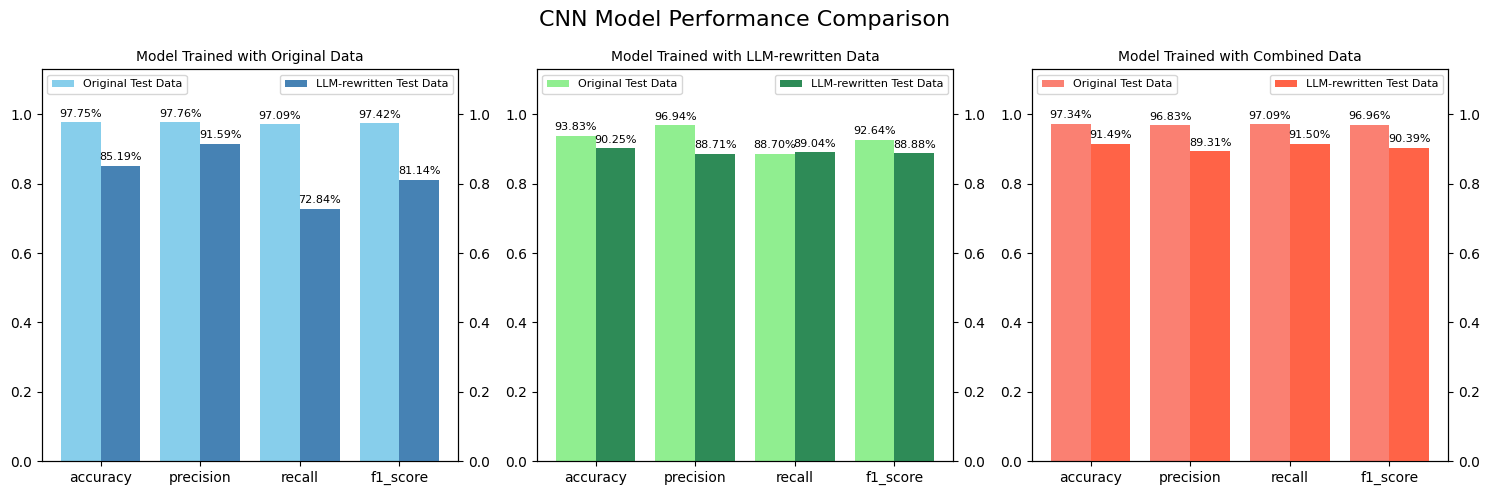

In [19]:

plot_results(
    "CNN",
    perf_original_model_val_data,
    perf_original_model_val_data_rewritten,
    perf_combined_model_val_data,
    perf_combined_model_val_data_rewritten,
    perf_rewritten_model_val_data,
    perf_rewritten_model_val_data_rewritten,
)